# Reproduction of grokking on a conv net for image classification

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [6]:
# Imports
import os
import datetime
import random
import glob
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Create dataset

In [52]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_frac=0.3, number_occurence=100, device='cpu'):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """

    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, int(train_frac*number_occurence)))
    val_idx = np.zeros((10, number_occurence - int(train_frac*number_occurence)))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, number_occurence)
        
        train_idx[number], val_idx[number] = train_test_split(random_selection, train_size=train_frac, random_state=seed)
        
    train_idx = train_idx.flatten().astype(int)
    np.random.shuffle(train_idx)
    
    val_idx = val_idx.flatten().astype(int)
    np.random.shuffle(val_idx)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx][:, None, :, :].double().to(device)
    Y_train = dataset.targets[train_idx].long().to(device)
    X_val = dataset.data[val_idx][:, None, :, :].double().to(device)
    Y_val = dataset.targets[val_idx].long().to(device)
    return X_train, Y_train, X_val, Y_val

# Step 2: Define model

In [93]:
# Default network architecture
img_size = 28
n_channels = 1
num_classes = 10

# Conv layers
num_filters = np.array([16])
filter_sizes = np.array([5])
pool_sizes = np.array([2])

# Fully connected layer
fc_layers = np.array([64])


class NumberDetector(nn.Module):
    def __init__(self):
        super(NumberDetector, self).__init__()
        
        # Add all conv layers in beginning
        self.conv_layers = []
        for i in range(num_filters.size):
            # Add conv
            if i == 0:
                self.conv_layers.append(nn.Conv2d(n_channels, num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))
            else:
                self.conv_layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))

            # Add pool
            if pool_sizes[i] > 1:
                self.conv_layers.append(torch.nn.MaxPool2d(kernel_size=(pool_sizes[i], pool_sizes[i])))

            # Add relu
            self.conv_layers.append(nn.ReLU())    
        
        self.conv_seq = nn.Sequential(*self.conv_layers)

        
        # Add fully connected layers
        # First layer
        self.lin_input_size = int(num_filters[-1] * ( img_size / np.prod(pool_sizes) )**2)
        self.lin_layers = [nn.Linear(self.lin_input_size, fc_layers[0]), nn.ReLU()]
        
        # Intermediate layers
        if fc_layers.size > 2:
            for i in range(1, fc_layers.size-1):
                self.lin_layers.append(nn.Linear(fc_layers[i-1, fc_layers[i]]))
                self.lin_layers.append(nn.ReLU())
    
        # Final layer
        self.lin_layers.append(nn.Linear(fc_layers[-1], num_classes))
        
        self.lin_seq = nn.Sequential(*self.lin_layers)

            
            
            
    def forward(self, x):
        # Conv layers
        x = self.conv_seq(x)

        # Fully connected layer
        x = x.view(-1, self.lin_input_size)
        x = self.lin_seq(x)

        return x
    
model = NumberDetector()

# Step 3: Training the model

In [94]:
def per_number_loss(predictions, labels, loss_fn):
    loss = np.zeros(10)
    for number in range(10):
        idx = np.where(labels.cpu()==number)
        number_pred = predictions[idx]
        number_label = labels[idx]
                
        loss[number] = loss_fn(number_pred, number_label)
    return loss
        
def kernel_ex_loss(X, y, model, loss_fn):
    pass

In [95]:
# Try to "turn off" a specific kernel (zero out)
def ex_loss(data, label, model, loss_fn):

    ex_loss = []
    
    for layer in model.conv_seq:
        ex_loss_layer = []
        
        if isinstance(layer, nn.Conv2d):
            for i in range(len(layer._parameters['weight'])):
                with torch.no_grad():
                    # Zero out weights
                    layer_backup = layer._parameters['weight'][i].clone().detach()
                    layer._parameters['weight'][i] = torch.DoubleTensor(np.zeros((1, 1, 5, 5)))
                    
                    # Calculate exclussion loss
                    pred = model(data)
                    loss = loss_fn(pred, label)
                    ex_loss_layer.append(loss)
                    
                    # Reset weights
                    layer._parameters['weight'][i] = layer_backup
            
            ex_loss.append(ex_loss_layer)
    
    return ex_loss

In [96]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector().double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Path already exists")
        
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_frac, number_occurence, device)
    
    # Allocate lists for loss storage
    steps_per_epoch = 1 + (len(Y_train)-1) // batch_size
    num_steps = num_epochs*steps_per_epoch
    
    train_losses = []
    val_losses = []
    
    train_number_losses = np.zeros((10, num_steps))
    val_number_losses = np.zeros((10, num_steps))
    
    train_ex_losses = []
    val_ex_losses = []
    

    # Mini-batch training
    batch_indices = np.split(np.arange(len(X_train)), np.where(np.arange(len(X_train)) % batch_size == 0)[0])[1:]
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        for i, batch_idx in enumerate(batch_indices):
            step = epoch*steps_per_epoch + i
            X_train_batch = X_train[batch_idx].double().to(device)
            Y_train_batch = Y_train[batch_idx].long().to(device)
            
            if calc_kernel_ex_loss and (epoch%calc_ex_loss_every == 0):
                train_ex_losses.append( ex_loss(X_train, Y_train, model, loss_fn) )
                val_ex_losses.append( ex_loss(X_val, Y_val, model, loss_fn) )

            # Calculate train and val loss
            train_pred = model(X_train)
            train_loss = loss_fn(train_pred, Y_train.to(device))
            train_losses.append(train_loss.item())

            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, Y_val.to(device))
            val_losses.append(val_loss.item())

            # Per number loss
            if calc_number_loss:
                train_number_losses[:, step] = per_number_loss(train_pred, Y_train, loss_fn)
                val_number_losses[:, step] = per_number_loss(val_pred, Y_val, loss_fn)


            # Print status
            if step%100 == 0: print(f"{step}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

            # Calc gradients and perform backprop
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if (save_models) and (step%save_every == 0):

                save_dict = {
                    'model': model.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'step': step,
                }
                torch.save(save_dict, save_root/run_name/f"{step}.pth")
                print(f"Saved model to {save_root/run_name/f'{step}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_number_losses': train_number_losses,
        'val_number_losses': val_number_losses,
        'train_ex_losses': train_ex_losses,
        'val_ex_losses': val_ex_losses,
        'step': step,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [105]:
# Random seeds for reproducability
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Model params
lr=1e-3
weight_decay = 1

# Training params
num_epochs = 10000
batch_size = 5
save_models = False
save_every = 500
save_root = Path("checkpoints")

# Dataset params
train_frac = 0.4
number_occurence = 10

calc_kernel_ex_loss = False
calc_ex_loss_every = 10
calc_number_loss = False

# Run training
exp_name = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
exp_name = "test"
train(exp_name)

Path already exists
Epoch 0
0_3.3633_3.2494
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
100_-7.6146_1.6871
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
200_-7.9025_1.3249
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
300_-8.3648_0.9224
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
400_-9.0512_0.5798
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
500_-10.0512_0.4022
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
600_-11.4206_0.3569
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
700_-13.0718_0.7654
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
E

Epoch 713
Epoch 714
Epoch 715
Epoch 716
Epoch 717
Epoch 718
Epoch 719
Epoch 720
Epoch 721
Epoch 722
Epoch 723
Epoch 724
Epoch 725
5800_-22.5243_0.7386
Epoch 726
Epoch 727
Epoch 728
Epoch 729
Epoch 730
Epoch 731
Epoch 732
Epoch 733
Epoch 734
Epoch 735
Epoch 736
Epoch 737
5900_-22.5255_0.7407
Epoch 738
Epoch 739
Epoch 740
Epoch 741
Epoch 742
Epoch 743
Epoch 744
Epoch 745
Epoch 746
Epoch 747
Epoch 748
Epoch 749
Epoch 750
6000_-22.5264_0.7432
Epoch 751
Epoch 752
Epoch 753
Epoch 754
Epoch 755
Epoch 756
Epoch 757
Epoch 758
Epoch 759
Epoch 760
Epoch 761
Epoch 762
6100_-22.5275_0.7457
Epoch 763
Epoch 764
Epoch 765
Epoch 766
Epoch 767
Epoch 768
Epoch 769
Epoch 770
Epoch 771
Epoch 772
Epoch 773
Epoch 774
Epoch 775
6200_-22.5286_0.7478
Epoch 776
Epoch 777
Epoch 778
Epoch 779
Epoch 780
Epoch 781
Epoch 782
Epoch 783
Epoch 784
Epoch 785
Epoch 786
Epoch 787
6300_-22.5294_0.7500
Epoch 788
Epoch 789
Epoch 790
Epoch 791
Epoch 792
Epoch 793
Epoch 794
Epoch 795
Epoch 796
Epoch 797
Epoch 798
Epoch 799
Epoc

Epoch 1382
Epoch 1383
Epoch 1384
Epoch 1385
Epoch 1386
Epoch 1387
11100_-22.5569_0.7712
Epoch 1388
Epoch 1389
Epoch 1390
Epoch 1391
Epoch 1392
Epoch 1393
Epoch 1394
Epoch 1395
Epoch 1396
Epoch 1397
Epoch 1398
Epoch 1399
Epoch 1400
11200_-22.5572_0.7710
Epoch 1401
Epoch 1402
Epoch 1403
Epoch 1404
Epoch 1405
Epoch 1406
Epoch 1407
Epoch 1408
Epoch 1409
Epoch 1410
Epoch 1411
Epoch 1412
11300_-22.5577_0.7703
Epoch 1413
Epoch 1414
Epoch 1415
Epoch 1416
Epoch 1417
Epoch 1418
Epoch 1419
Epoch 1420
Epoch 1421
Epoch 1422
Epoch 1423
Epoch 1424
Epoch 1425
11400_-22.5577_0.7699
Epoch 1426
Epoch 1427
Epoch 1428
Epoch 1429
Epoch 1430
Epoch 1431
Epoch 1432
Epoch 1433
Epoch 1434
Epoch 1435
Epoch 1436
Epoch 1437
11500_-22.5581_0.7693
Epoch 1438
Epoch 1439
Epoch 1440
Epoch 1441
Epoch 1442
Epoch 1443
Epoch 1444
Epoch 1445
Epoch 1446
Epoch 1447
Epoch 1448
Epoch 1449
Epoch 1450
11600_-22.5584_0.7692
Epoch 1451
Epoch 1452
Epoch 1453
Epoch 1454
Epoch 1455
Epoch 1456
Epoch 1457
Epoch 1458
Epoch 1459
Epoch 1460

Epoch 2025
16200_-22.5696_0.7582
Epoch 2026
Epoch 2027
Epoch 2028
Epoch 2029
Epoch 2030
Epoch 2031
Epoch 2032
Epoch 2033
Epoch 2034
Epoch 2035
Epoch 2036
Epoch 2037
16300_-22.5695_0.7581
Epoch 2038
Epoch 2039
Epoch 2040
Epoch 2041
Epoch 2042
Epoch 2043
Epoch 2044
Epoch 2045
Epoch 2046
Epoch 2047
Epoch 2048
Epoch 2049
Epoch 2050
16400_-22.5701_0.7579
Epoch 2051
Epoch 2052
Epoch 2053
Epoch 2054
Epoch 2055
Epoch 2056
Epoch 2057
Epoch 2058
Epoch 2059
Epoch 2060
Epoch 2061
Epoch 2062
16500_-22.5699_0.7577
Epoch 2063
Epoch 2064
Epoch 2065
Epoch 2066
Epoch 2067
Epoch 2068
Epoch 2069
Epoch 2070
Epoch 2071
Epoch 2072
Epoch 2073
Epoch 2074
Epoch 2075
16600_-22.5704_0.7577
Epoch 2076
Epoch 2077
Epoch 2078
Epoch 2079
Epoch 2080
Epoch 2081
Epoch 2082
Epoch 2083
Epoch 2084
Epoch 2085
Epoch 2086
Epoch 2087
16700_-22.5704_0.7578
Epoch 2088
Epoch 2089
Epoch 2090
Epoch 2091
Epoch 2092
Epoch 2093
Epoch 2094
Epoch 2095
Epoch 2096
Epoch 2097
Epoch 2098
Epoch 2099
Epoch 2100
16800_-22.5704_0.7577
Epoch 2101

Epoch 2669
Epoch 2670
Epoch 2671
Epoch 2672
Epoch 2673
Epoch 2674
Epoch 2675
21400_-22.5788_0.7523
Epoch 2676
Epoch 2677
Epoch 2678
Epoch 2679
Epoch 2680
Epoch 2681
Epoch 2682
Epoch 2683
Epoch 2684
Epoch 2685
Epoch 2686
Epoch 2687
21500_-22.5792_0.7521
Epoch 2688
Epoch 2689
Epoch 2690
Epoch 2691
Epoch 2692
Epoch 2693
Epoch 2694
Epoch 2695
Epoch 2696
Epoch 2697
Epoch 2698
Epoch 2699
Epoch 2700
21600_-22.5792_0.7521
Epoch 2701
Epoch 2702
Epoch 2703
Epoch 2704
Epoch 2705
Epoch 2706
Epoch 2707
Epoch 2708
Epoch 2709
Epoch 2710
Epoch 2711
Epoch 2712
21700_-22.5790_0.7518
Epoch 2713
Epoch 2714
Epoch 2715
Epoch 2716
Epoch 2717
Epoch 2718
Epoch 2719
Epoch 2720
Epoch 2721
Epoch 2722
Epoch 2723
Epoch 2724
Epoch 2725
21800_-22.5792_0.7520
Epoch 2726
Epoch 2727
Epoch 2728
Epoch 2729
Epoch 2730
Epoch 2731
Epoch 2732
Epoch 2733
Epoch 2734
Epoch 2735
Epoch 2736
Epoch 2737
21900_-22.5793_0.7516
Epoch 2738
Epoch 2739
Epoch 2740
Epoch 2741
Epoch 2742
Epoch 2743
Epoch 2744
Epoch 2745
Epoch 2746
Epoch 2747

Epoch 3312
26500_-22.5860_0.7488
Epoch 3313
Epoch 3314
Epoch 3315
Epoch 3316
Epoch 3317
Epoch 3318
Epoch 3319
Epoch 3320
Epoch 3321
Epoch 3322
Epoch 3323
Epoch 3324
Epoch 3325
26600_-22.5858_0.7489
Epoch 3326
Epoch 3327
Epoch 3328
Epoch 3329
Epoch 3330
Epoch 3331
Epoch 3332
Epoch 3333
Epoch 3334
Epoch 3335
Epoch 3336
Epoch 3337
26700_-22.5863_0.7488
Epoch 3338
Epoch 3339
Epoch 3340
Epoch 3341
Epoch 3342
Epoch 3343
Epoch 3344
Epoch 3345
Epoch 3346
Epoch 3347
Epoch 3348
Epoch 3349
Epoch 3350
26800_-22.5851_0.7483
Epoch 3351
Epoch 3352
Epoch 3353
Epoch 3354
Epoch 3355
Epoch 3356
Epoch 3357
Epoch 3358
Epoch 3359
Epoch 3360
Epoch 3361
Epoch 3362
26900_-22.5864_0.7488
Epoch 3363
Epoch 3364
Epoch 3365
Epoch 3366
Epoch 3367
Epoch 3368
Epoch 3369
Epoch 3370
Epoch 3371
Epoch 3372
Epoch 3373
Epoch 3374
Epoch 3375
27000_-22.5863_0.7484
Epoch 3376
Epoch 3377
Epoch 3378
Epoch 3379
Epoch 3380
Epoch 3381
Epoch 3382
Epoch 3383
Epoch 3384
Epoch 3385
Epoch 3386
Epoch 3387
27100_-22.5862_0.7483
Epoch 3388

Epoch 3956
Epoch 3957
Epoch 3958
Epoch 3959
Epoch 3960
Epoch 3961
Epoch 3962
31700_-22.5900_0.7474
Epoch 3963
Epoch 3964
Epoch 3965
Epoch 3966
Epoch 3967
Epoch 3968
Epoch 3969
Epoch 3970
Epoch 3971
Epoch 3972
Epoch 3973
Epoch 3974
Epoch 3975
31800_-22.5909_0.7473
Epoch 3976
Epoch 3977
Epoch 3978
Epoch 3979
Epoch 3980
Epoch 3981
Epoch 3982
Epoch 3983
Epoch 3984
Epoch 3985
Epoch 3986
Epoch 3987
31900_-22.5907_0.7473
Epoch 3988
Epoch 3989
Epoch 3990
Epoch 3991
Epoch 3992
Epoch 3993
Epoch 3994
Epoch 3995
Epoch 3996
Epoch 3997
Epoch 3998
Epoch 3999
Epoch 4000
32000_-22.5909_0.7475
Epoch 4001
Epoch 4002
Epoch 4003
Epoch 4004
Epoch 4005
Epoch 4006
Epoch 4007
Epoch 4008
Epoch 4009
Epoch 4010
Epoch 4011
Epoch 4012
32100_-22.5911_0.7472
Epoch 4013
Epoch 4014
Epoch 4015
Epoch 4016
Epoch 4017
Epoch 4018
Epoch 4019
Epoch 4020
Epoch 4021
Epoch 4022
Epoch 4023
Epoch 4024
Epoch 4025
32200_-22.5904_0.7472
Epoch 4026
Epoch 4027
Epoch 4028
Epoch 4029
Epoch 4030
Epoch 4031
Epoch 4032
Epoch 4033
Epoch 4034

Epoch 4602
Epoch 4603
Epoch 4604
Epoch 4605
Epoch 4606
Epoch 4607
Epoch 4608
Epoch 4609
Epoch 4610
Epoch 4611
Epoch 4612
36900_-22.5939_0.7463
Epoch 4613
Epoch 4614
Epoch 4615
Epoch 4616
Epoch 4617
Epoch 4618
Epoch 4619
Epoch 4620
Epoch 4621
Epoch 4622
Epoch 4623
Epoch 4624
Epoch 4625
37000_-22.5934_0.7464
Epoch 4626
Epoch 4627
Epoch 4628
Epoch 4629
Epoch 4630
Epoch 4631
Epoch 4632
Epoch 4633
Epoch 4634
Epoch 4635
Epoch 4636
Epoch 4637
37100_-22.5931_0.7464
Epoch 4638
Epoch 4639
Epoch 4640
Epoch 4641
Epoch 4642
Epoch 4643
Epoch 4644
Epoch 4645
Epoch 4646
Epoch 4647
Epoch 4648
Epoch 4649
Epoch 4650
37200_-22.5936_0.7465
Epoch 4651
Epoch 4652
Epoch 4653
Epoch 4654
Epoch 4655
Epoch 4656
Epoch 4657
Epoch 4658
Epoch 4659
Epoch 4660
Epoch 4661
Epoch 4662
37300_-22.5939_0.7465
Epoch 4663
Epoch 4664
Epoch 4665
Epoch 4666
Epoch 4667
Epoch 4668
Epoch 4669
Epoch 4670
Epoch 4671
Epoch 4672
Epoch 4673
Epoch 4674
Epoch 4675
37400_-22.5939_0.7467
Epoch 4676
Epoch 4677
Epoch 4678
Epoch 4679
Epoch 4680

Epoch 5245
Epoch 5246
Epoch 5247
Epoch 5248
Epoch 5249
Epoch 5250
42000_-22.5959_0.7481
Epoch 5251
Epoch 5252
Epoch 5253
Epoch 5254
Epoch 5255
Epoch 5256
Epoch 5257
Epoch 5258
Epoch 5259
Epoch 5260
Epoch 5261
Epoch 5262
42100_-22.5956_0.7480
Epoch 5263
Epoch 5264
Epoch 5265
Epoch 5266
Epoch 5267
Epoch 5268
Epoch 5269
Epoch 5270
Epoch 5271
Epoch 5272
Epoch 5273
Epoch 5274
Epoch 5275
42200_-22.5959_0.7482
Epoch 5276
Epoch 5277
Epoch 5278
Epoch 5279
Epoch 5280
Epoch 5281
Epoch 5282
Epoch 5283
Epoch 5284
Epoch 5285
Epoch 5286
Epoch 5287
42300_-22.5958_0.7484
Epoch 5288
Epoch 5289
Epoch 5290
Epoch 5291
Epoch 5292
Epoch 5293
Epoch 5294
Epoch 5295
Epoch 5296
Epoch 5297
Epoch 5298
Epoch 5299
Epoch 5300
42400_-22.5957_0.7484
Epoch 5301
Epoch 5302
Epoch 5303
Epoch 5304
Epoch 5305
Epoch 5306
Epoch 5307
Epoch 5308
Epoch 5309
Epoch 5310
Epoch 5311
Epoch 5312
42500_-22.5958_0.7482
Epoch 5313
Epoch 5314
Epoch 5315
Epoch 5316
Epoch 5317
Epoch 5318
Epoch 5319
Epoch 5320
Epoch 5321
Epoch 5322
Epoch 5323

47100_-22.5969_0.7487
Epoch 5888
Epoch 5889
Epoch 5890
Epoch 5891
Epoch 5892
Epoch 5893
Epoch 5894
Epoch 5895
Epoch 5896
Epoch 5897
Epoch 5898
Epoch 5899
Epoch 5900
47200_-22.5966_0.7484
Epoch 5901
Epoch 5902
Epoch 5903
Epoch 5904
Epoch 5905
Epoch 5906
Epoch 5907
Epoch 5908
Epoch 5909
Epoch 5910
Epoch 5911
Epoch 5912
47300_-22.5976_0.7487
Epoch 5913
Epoch 5914
Epoch 5915
Epoch 5916
Epoch 5917
Epoch 5918
Epoch 5919
Epoch 5920
Epoch 5921
Epoch 5922
Epoch 5923
Epoch 5924
Epoch 5925
47400_-22.5971_0.7484
Epoch 5926
Epoch 5927
Epoch 5928
Epoch 5929
Epoch 5930
Epoch 5931
Epoch 5932
Epoch 5933
Epoch 5934
Epoch 5935
Epoch 5936
Epoch 5937
47500_-22.5972_0.7485
Epoch 5938
Epoch 5939
Epoch 5940
Epoch 5941
Epoch 5942
Epoch 5943
Epoch 5944
Epoch 5945
Epoch 5946
Epoch 5947
Epoch 5948
Epoch 5949
Epoch 5950
47600_-22.5975_0.7485
Epoch 5951
Epoch 5952
Epoch 5953
Epoch 5954
Epoch 5955
Epoch 5956
Epoch 5957
Epoch 5958
Epoch 5959
Epoch 5960
Epoch 5961
Epoch 5962
47700_-22.5971_0.7487
Epoch 5963
Epoch 5964

Epoch 6532
Epoch 6533
Epoch 6534
Epoch 6535
Epoch 6536
Epoch 6537
52300_-22.5984_0.7525
Epoch 6538
Epoch 6539
Epoch 6540
Epoch 6541
Epoch 6542
Epoch 6543
Epoch 6544
Epoch 6545
Epoch 6546
Epoch 6547
Epoch 6548
Epoch 6549
Epoch 6550
52400_-22.5984_0.7526
Epoch 6551
Epoch 6552
Epoch 6553
Epoch 6554
Epoch 6555
Epoch 6556
Epoch 6557
Epoch 6558
Epoch 6559
Epoch 6560
Epoch 6561
Epoch 6562
52500_-22.5986_0.7525
Epoch 6563
Epoch 6564
Epoch 6565
Epoch 6566
Epoch 6567
Epoch 6568
Epoch 6569
Epoch 6570
Epoch 6571
Epoch 6572
Epoch 6573
Epoch 6574
Epoch 6575
52600_-22.5981_0.7528
Epoch 6576
Epoch 6577
Epoch 6578
Epoch 6579
Epoch 6580
Epoch 6581
Epoch 6582
Epoch 6583
Epoch 6584
Epoch 6585
Epoch 6586
Epoch 6587
52700_-22.5984_0.7528
Epoch 6588
Epoch 6589
Epoch 6590
Epoch 6591
Epoch 6592
Epoch 6593
Epoch 6594
Epoch 6595
Epoch 6596
Epoch 6597
Epoch 6598
Epoch 6599
Epoch 6600
52800_-22.5983_0.7526
Epoch 6601
Epoch 6602
Epoch 6603
Epoch 6604
Epoch 6605
Epoch 6606
Epoch 6607
Epoch 6608
Epoch 6609
Epoch 6610

Epoch 7178
Epoch 7179
Epoch 7180
Epoch 7181
Epoch 7182
Epoch 7183
Epoch 7184
Epoch 7185
Epoch 7186
Epoch 7187
57500_-22.5991_0.7543
Epoch 7188
Epoch 7189
Epoch 7190
Epoch 7191
Epoch 7192
Epoch 7193
Epoch 7194
Epoch 7195
Epoch 7196
Epoch 7197
Epoch 7198
Epoch 7199
Epoch 7200
57600_-22.5991_0.7544
Epoch 7201
Epoch 7202
Epoch 7203
Epoch 7204
Epoch 7205
Epoch 7206
Epoch 7207
Epoch 7208
Epoch 7209
Epoch 7210
Epoch 7211
Epoch 7212
57700_-22.5987_0.7549
Epoch 7213
Epoch 7214
Epoch 7215
Epoch 7216
Epoch 7217
Epoch 7218
Epoch 7219
Epoch 7220
Epoch 7221
Epoch 7222
Epoch 7223
Epoch 7224
Epoch 7225
57800_-22.5993_0.7547
Epoch 7226
Epoch 7227
Epoch 7228
Epoch 7229
Epoch 7230
Epoch 7231
Epoch 7232
Epoch 7233
Epoch 7234
Epoch 7235
Epoch 7236
Epoch 7237
57900_-22.5987_0.7546
Epoch 7238
Epoch 7239
Epoch 7240
Epoch 7241
Epoch 7242
Epoch 7243
Epoch 7244
Epoch 7245
Epoch 7246
Epoch 7247
Epoch 7248
Epoch 7249
Epoch 7250
58000_-22.5991_0.7548
Epoch 7251
Epoch 7252
Epoch 7253
Epoch 7254
Epoch 7255
Epoch 7256

Epoch 7823
Epoch 7824
Epoch 7825
62600_-22.5998_0.7573
Epoch 7826
Epoch 7827
Epoch 7828
Epoch 7829
Epoch 7830
Epoch 7831
Epoch 7832
Epoch 7833
Epoch 7834
Epoch 7835
Epoch 7836
Epoch 7837
62700_-22.5996_0.7571
Epoch 7838
Epoch 7839
Epoch 7840
Epoch 7841
Epoch 7842
Epoch 7843
Epoch 7844
Epoch 7845
Epoch 7846
Epoch 7847
Epoch 7848
Epoch 7849
Epoch 7850
62800_-22.6000_0.7572
Epoch 7851
Epoch 7852
Epoch 7853
Epoch 7854
Epoch 7855
Epoch 7856
Epoch 7857
Epoch 7858
Epoch 7859
Epoch 7860
Epoch 7861
Epoch 7862
62900_-22.6001_0.7572
Epoch 7863
Epoch 7864
Epoch 7865
Epoch 7866
Epoch 7867
Epoch 7868
Epoch 7869
Epoch 7870
Epoch 7871
Epoch 7872
Epoch 7873
Epoch 7874
Epoch 7875
63000_-22.5999_0.7573
Epoch 7876
Epoch 7877
Epoch 7878
Epoch 7879
Epoch 7880
Epoch 7881
Epoch 7882
Epoch 7883
Epoch 7884
Epoch 7885
Epoch 7886
Epoch 7887
63100_-22.6002_0.7573
Epoch 7888
Epoch 7889
Epoch 7890
Epoch 7891
Epoch 7892
Epoch 7893
Epoch 7894
Epoch 7895
Epoch 7896
Epoch 7897
Epoch 7898
Epoch 7899
Epoch 7900
63200_-22.

Epoch 8466
Epoch 8467
Epoch 8468
Epoch 8469
Epoch 8470
Epoch 8471
Epoch 8472
Epoch 8473
Epoch 8474
Epoch 8475
67800_-22.6000_0.7583
Epoch 8476
Epoch 8477
Epoch 8478
Epoch 8479
Epoch 8480
Epoch 8481
Epoch 8482
Epoch 8483
Epoch 8484
Epoch 8485
Epoch 8486
Epoch 8487
67900_-22.6008_0.7582
Epoch 8488
Epoch 8489
Epoch 8490
Epoch 8491
Epoch 8492
Epoch 8493
Epoch 8494
Epoch 8495
Epoch 8496
Epoch 8497
Epoch 8498
Epoch 8499
Epoch 8500
68000_-22.6004_0.7582
Epoch 8501
Epoch 8502
Epoch 8503
Epoch 8504
Epoch 8505
Epoch 8506
Epoch 8507
Epoch 8508
Epoch 8509
Epoch 8510
Epoch 8511
Epoch 8512
68100_-22.6006_0.7582
Epoch 8513
Epoch 8514
Epoch 8515
Epoch 8516
Epoch 8517
Epoch 8518
Epoch 8519
Epoch 8520
Epoch 8521
Epoch 8522
Epoch 8523
Epoch 8524
Epoch 8525
68200_-22.6008_0.7581
Epoch 8526
Epoch 8527
Epoch 8528
Epoch 8529
Epoch 8530
Epoch 8531
Epoch 8532
Epoch 8533
Epoch 8534
Epoch 8535
Epoch 8536
Epoch 8537
68300_-22.6009_0.7580
Epoch 8538
Epoch 8539
Epoch 8540
Epoch 8541
Epoch 8542
Epoch 8543
Epoch 8544

Epoch 9109
Epoch 9110
Epoch 9111
Epoch 9112
72900_-22.6007_0.7592
Epoch 9113
Epoch 9114
Epoch 9115
Epoch 9116
Epoch 9117
Epoch 9118
Epoch 9119
Epoch 9120
Epoch 9121
Epoch 9122
Epoch 9123
Epoch 9124
Epoch 9125
73000_-22.6006_0.7593
Epoch 9126
Epoch 9127
Epoch 9128
Epoch 9129
Epoch 9130
Epoch 9131
Epoch 9132
Epoch 9133
Epoch 9134
Epoch 9135
Epoch 9136
Epoch 9137
73100_-22.6011_0.7589
Epoch 9138
Epoch 9139
Epoch 9140
Epoch 9141
Epoch 9142
Epoch 9143
Epoch 9144
Epoch 9145
Epoch 9146
Epoch 9147
Epoch 9148
Epoch 9149
Epoch 9150
73200_-22.6013_0.7590
Epoch 9151
Epoch 9152
Epoch 9153
Epoch 9154
Epoch 9155
Epoch 9156
Epoch 9157
Epoch 9158
Epoch 9159
Epoch 9160
Epoch 9161
Epoch 9162
73300_-22.6010_0.7591
Epoch 9163
Epoch 9164
Epoch 9165
Epoch 9166
Epoch 9167
Epoch 9168
Epoch 9169
Epoch 9170
Epoch 9171
Epoch 9172
Epoch 9173
Epoch 9174
Epoch 9175
73400_-22.6013_0.7590
Epoch 9176
Epoch 9177
Epoch 9178
Epoch 9179
Epoch 9180
Epoch 9181
Epoch 9182
Epoch 9183
Epoch 9184
Epoch 9185
Epoch 9186
Epoch 9187

Epoch 9752
Epoch 9753
Epoch 9754
Epoch 9755
Epoch 9756
Epoch 9757
Epoch 9758
Epoch 9759
Epoch 9760
Epoch 9761
Epoch 9762
78100_-22.6018_0.7603
Epoch 9763
Epoch 9764
Epoch 9765
Epoch 9766
Epoch 9767
Epoch 9768
Epoch 9769
Epoch 9770
Epoch 9771
Epoch 9772
Epoch 9773
Epoch 9774
Epoch 9775
78200_-22.6018_0.7600
Epoch 9776
Epoch 9777
Epoch 9778
Epoch 9779
Epoch 9780
Epoch 9781
Epoch 9782
Epoch 9783
Epoch 9784
Epoch 9785
Epoch 9786
Epoch 9787
78300_-22.6014_0.7605
Epoch 9788
Epoch 9789
Epoch 9790
Epoch 9791
Epoch 9792
Epoch 9793
Epoch 9794
Epoch 9795
Epoch 9796
Epoch 9797
Epoch 9798
Epoch 9799
Epoch 9800
78400_-22.6016_0.7603
Epoch 9801
Epoch 9802
Epoch 9803
Epoch 9804
Epoch 9805
Epoch 9806
Epoch 9807
Epoch 9808
Epoch 9809
Epoch 9810
Epoch 9811
Epoch 9812
78500_-22.6021_0.7602
Epoch 9813
Epoch 9814
Epoch 9815
Epoch 9816
Epoch 9817
Epoch 9818
Epoch 9819
Epoch 9820
Epoch 9821
Epoch 9822
Epoch 9823
Epoch 9824
Epoch 9825
78600_-22.6017_0.7604
Epoch 9826
Epoch 9827
Epoch 9828
Epoch 9829
Epoch 9830

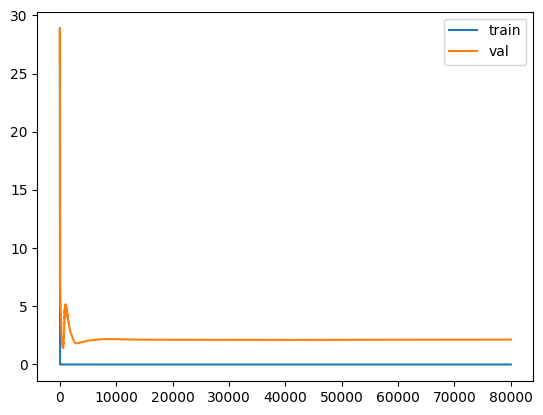

In [106]:
#Train versus val errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
plt.plot(load_dict['train_losses'], label='train')
plt.plot(load_dict['val_losses'], label="val")

plt.legend()

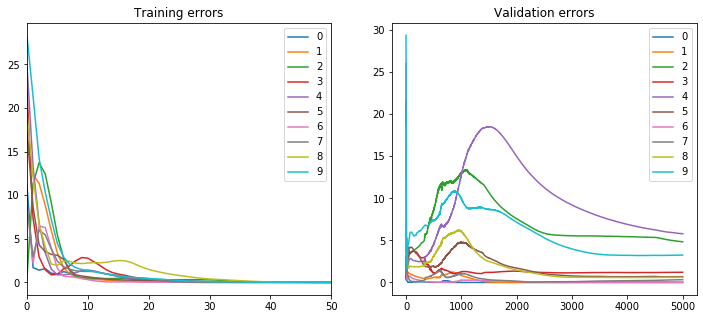

In [202]:
# Visualize per-number errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

fig, ax = plt.subplots(1, 2,  figsize=(12, 5))

for number, losses in enumerate(load_dict['train_number_losses']):
    ax[0].set_title("Training errors")
    ax[0].plot(losses, label=str(number))
    ax[0].legend()
    ax[0].set_xlim(0, 50)

    
for number, losses in enumerate(load_dict['val_number_losses']):
    ax[1].set_title("Validation errors")
    ax[1].plot(losses, label=str(number))
    ax[1].legend()

plt.show()

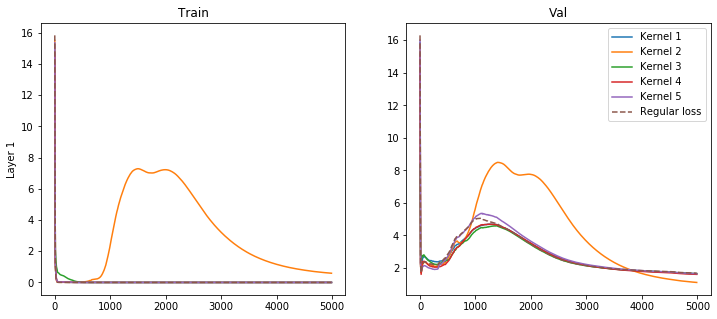

In [203]:
# Plot exclusion losses
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

train_ex_losses = load_dict['train_ex_losses']
train_losses = load_dict['train_losses']
val_ex_losses = load_dict['val_ex_losses']
val_losses = load_dict['val_losses']

n_layers = len(train_ex_losses[0])
timesteps = np.arange(0, num_epochs, calc_ex_loss_every)

fig, ax = plt.subplots(n_layers, 2, figsize=(12, 5*n_layers))

for layer_idx in range(n_layers):
    layer_ax = ax[layer_idx] if n_layers > 1 else ax
    # Allocate memory 
    num_kernels = len(train_ex_losses[0][layer_idx])
    layer_losses = np.zeros((2, num_kernels, timesteps.size))

    # Gather data for each time step
    for t in range(timesteps.size):
        layer_losses[0, :, t] = train_ex_losses[t][layer_idx]
        layer_losses[1, :, t] = val_ex_losses[t][layer_idx]
        
    # For each kernel, plot its corresponding graph
    for i in range(num_kernels):
        layer_ax[0].plot(timesteps, layer_losses[0, i, :],  label=f"Kernel {i+1}")
        layer_ax[1].plot(timesteps, layer_losses[1, i, :],  label=f"Kernel {i+1}")
    
    layer_ax[0].plot(timesteps, train_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[0].set_title("Train")
    
    layer_ax[1].plot(timesteps, val_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[1].set_title("Val")
    
    layer_ax[1].legend()
    layer_ax[0].set_ylabel(f"Layer {layer_idx+1}")


0 0
1 500
2 1000
3 1500
4 2000
5 2500
6 3000
7 3500
8 4000
9 4500
10 5000


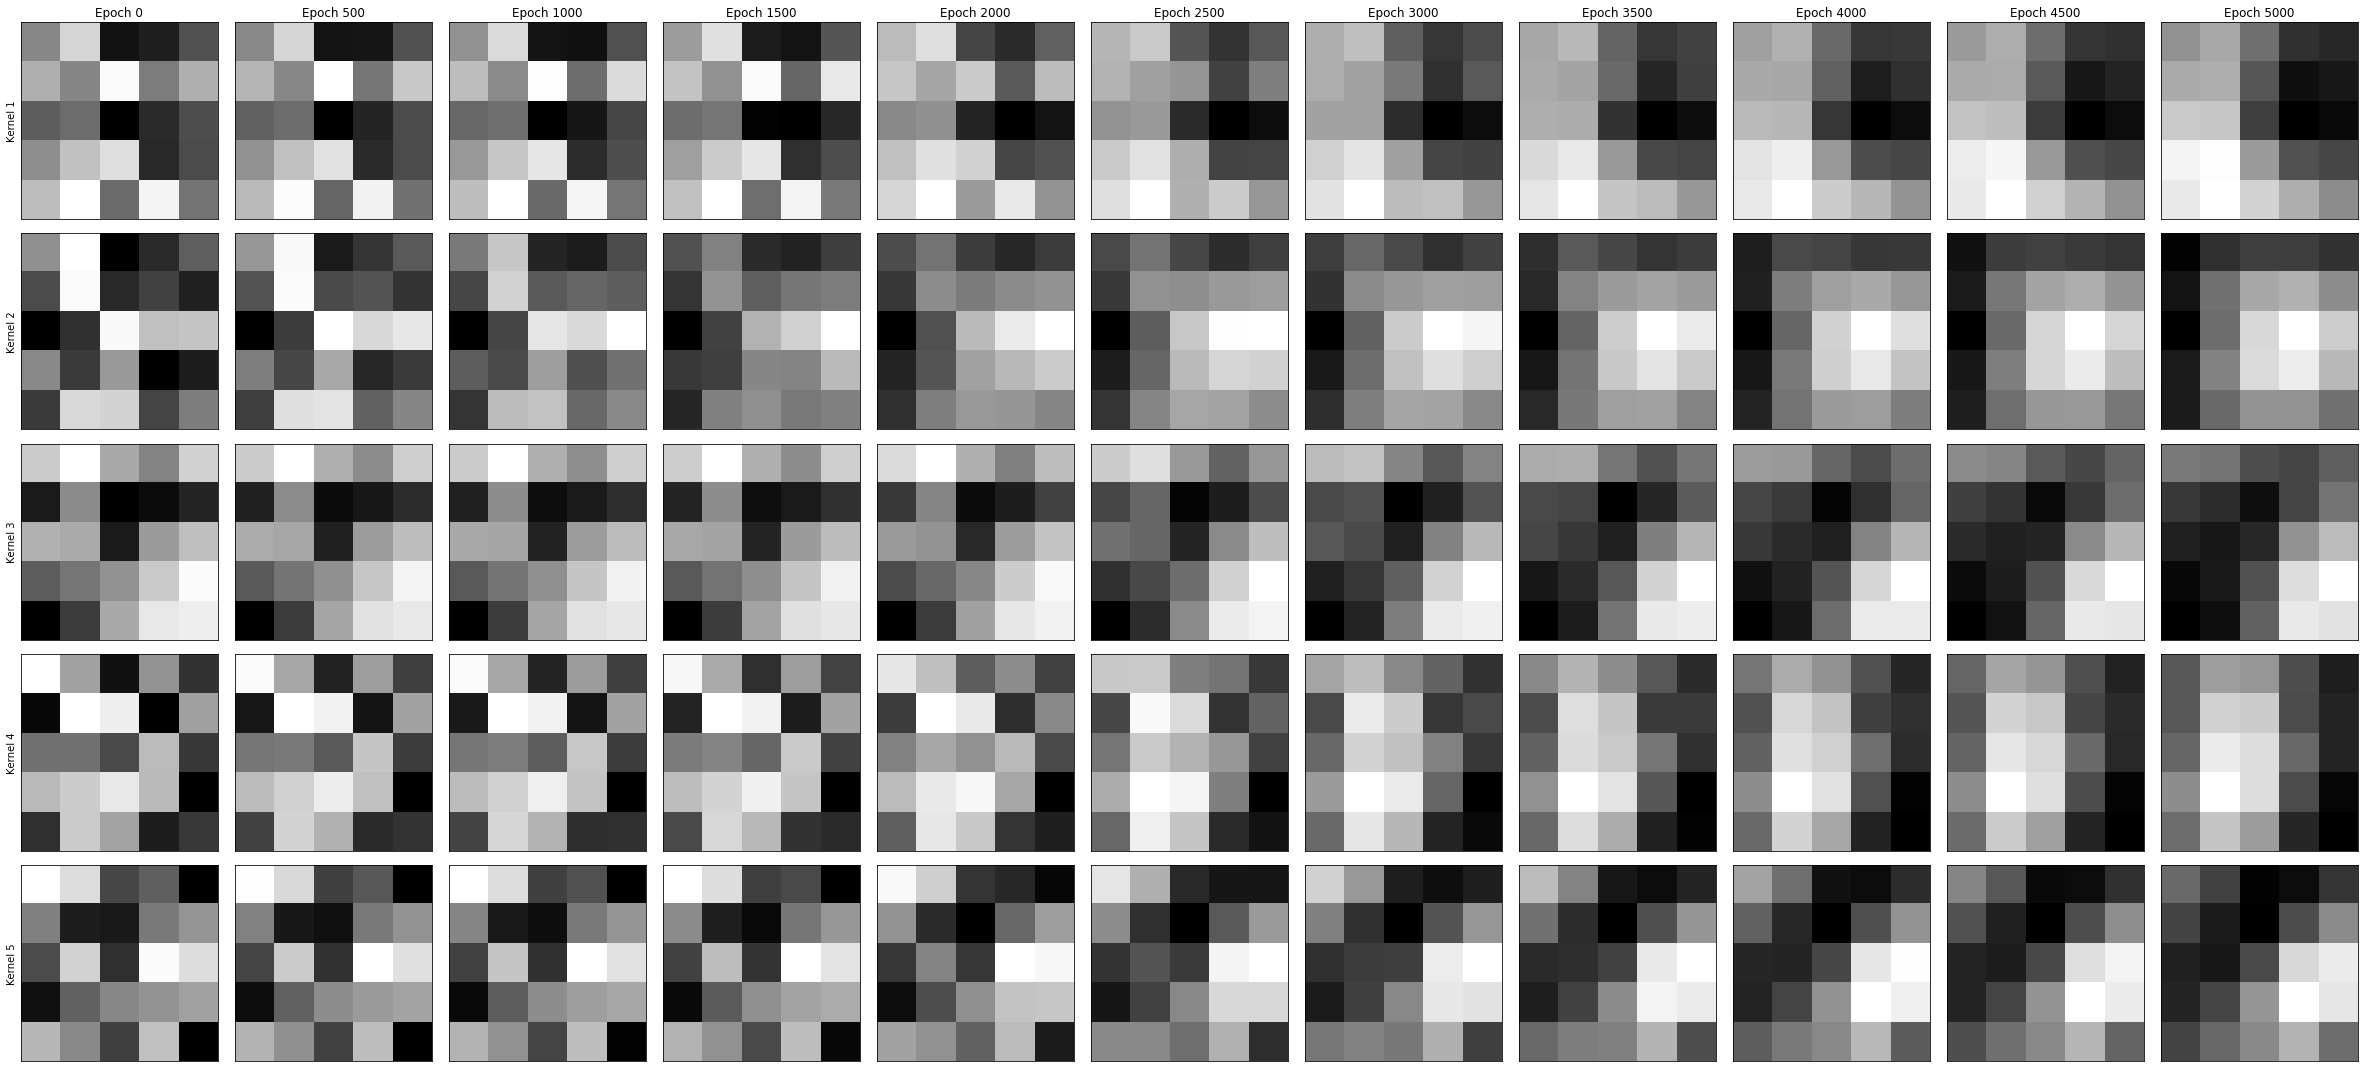

In [208]:
# Visualize kernels
def visualize_kernels(layer_num=1):
    cpts = glob.glob(f"checkpoints/{exp_name}/*")
    
    
    kernels = {}
    
    for cpt in cpts:
        if 'init' in cpt:
            continue
        elif 'final' in cpt:
            epoch = num_epochs
        else:
            epoch = int(os.path.basename(cpt).split(".")[0])
            
        load_dict = torch.load(cpt)
        
        kernels[epoch] = load_dict['model'][f'conv_seq.{layer_num-1}.weight']
        

    n_cols = len(list(kernels.items()))
    n_rows = len(list(kernels.items())[0][1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    
    for i, epoch in enumerate(sorted(kernels)):
        print(i, epoch)
        
        for j, kernel in enumerate(kernels[epoch].squeeze()):
            ax = axs[j][i] 

            # Layout
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(kernel.cpu(), cmap='gray')
        
            if i == 0:
                ax.set_ylabel(f"Kernel {j+1}")
            if j == 0:
                ax.set_title(f"Epoch {epoch}")
    plt.tight_layout()
        
visualize_kernels()